In [1]:
import os, sys
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomZoom, RandomContrast, RandomRotation
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv2DTranspose, Concatenate, MaxPooling2D, Dropout
from tensorflow_addons.metrics import F1Score
import tensorflow_datasets as tfds
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(f'Running on Python {sys.version}, Tensorflow {tf.__version__}.')

Running on Python 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)], Tensorflow 2.5.0.


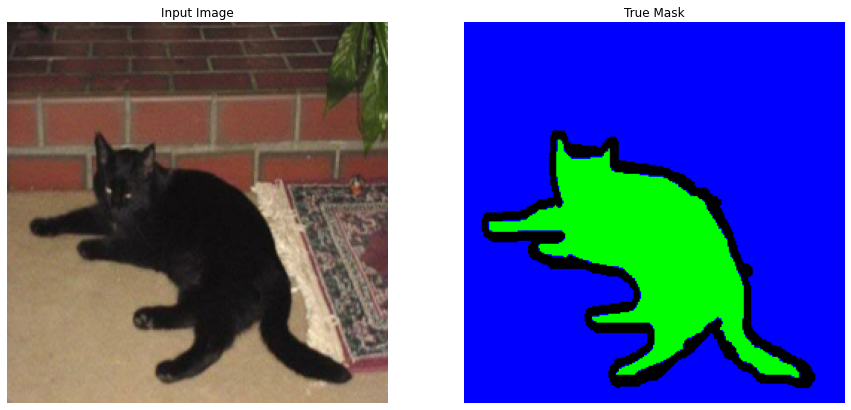

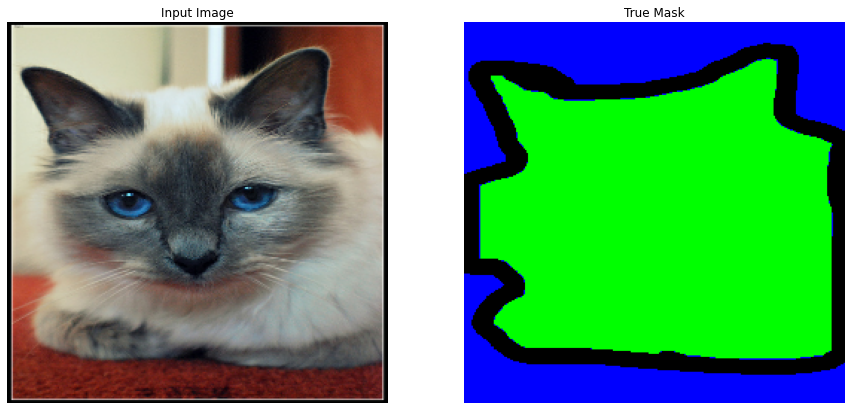

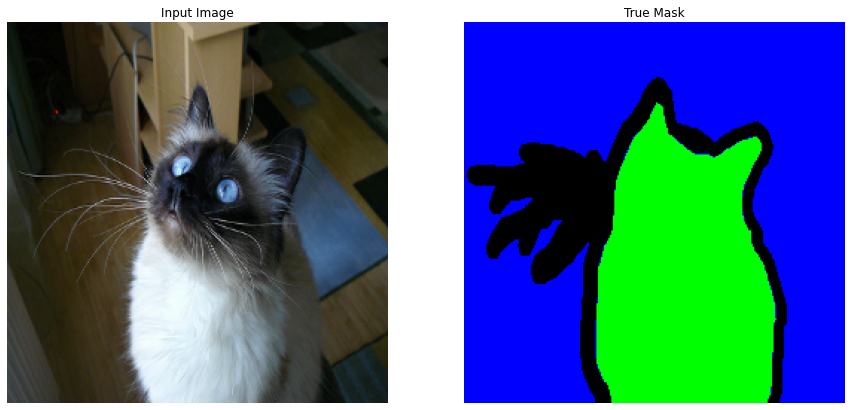

In [2]:
batch_size = 16
img_height, img_width = 256, 256
no_classes = 3
(train, val, test), ds_info = tfds.load('oxford_iiit_pet', with_info=True, shuffle_files=True, split=['train', 'test[:50%]', 'test[50%:]'])

def preprocess(datapoint):
    img = tf.image.resize(datapoint['image'], (img_height, img_width))
    mask = tf.image.resize(datapoint['segmentation_mask'], (img_height, img_width))
    return img, tf.squeeze(tf.cast(tf.one_hot(tf.cast(mask, tf.int64), no_classes), tf.float32))  # per pixel one hot encoding

train = train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val = val.map(preprocess)
test = test.map(preprocess)

train_ds = train.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image, mask in test.take(3):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [3]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    inputs = Input(input_shape)

    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    for layer in resnet50.layers:
        layer.trainable = False  # freeze layers

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output
    s2 = resnet50.get_layer("conv1_relu").output
    s3 = resnet50.get_layer("conv2_block3_out").output
    s4 = resnet50.get_layer("conv3_block4_out").output

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, img_height/(2**0))
    d2 = decoder_block(d1, s3, img_height/(2**1))
    d3 = decoder_block(d2, s2, img_height/(2**2))
    d4 = decoder_block(d3, s1, img_height/(2**3))

    """ Output """
    outputs = Conv2D(no_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

def dice(y_true, y_pred, smooth=1e-6):
  numerator = 2. * tf.reduce_sum(y_true * y_pred) + smooth
  denominator = tf.reduce_sum(y_true + y_pred) + smooth
  return tf.reduce_mean(numerator / denominator)

def dice_loss(y_true, y_pred):
    return 1 - dice(y_true, y_pred)

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_____________________________________________________________________________________

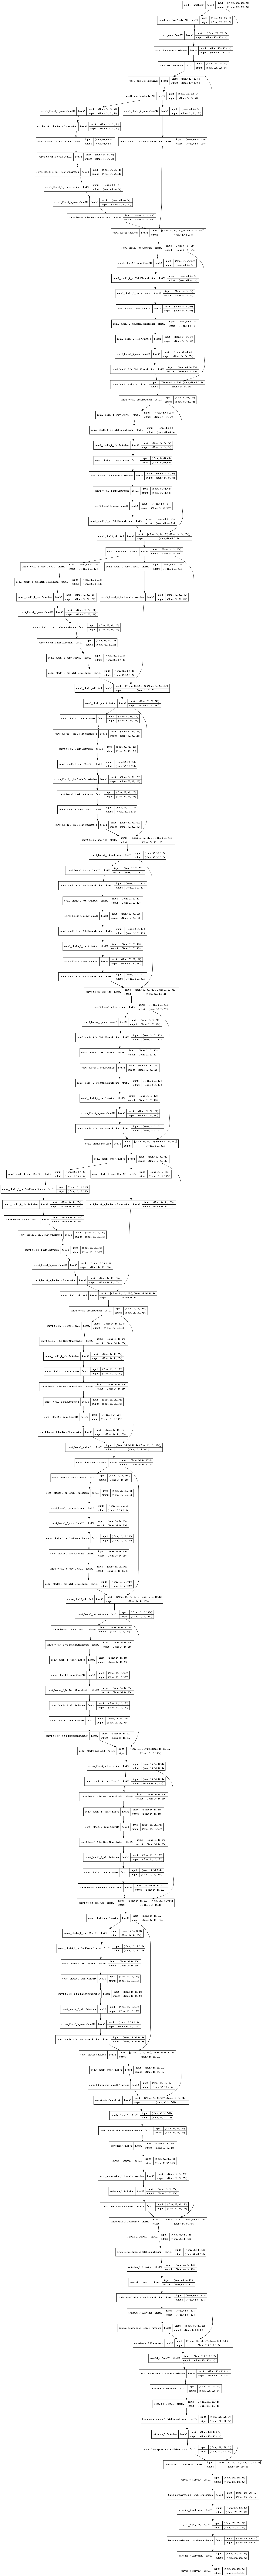

In [4]:
opt = keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-6)
# opt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.99)
loss = dice_loss
reg = keras.regularizers.L2(1e-5)
metrics = [dice]  # keras.metrics.MeanIoU(num_classes=no_classes), F1Score(num_classes=no_classes)
epoch = 100
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_dice', min_delta=0, patience=10, verbose=1,
                                     mode='auto', baseline=None, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('./best_model',monitor='val_dice',save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice', factor=0.1, patience=3, verbose=1),
    DisplayCallback()]

input_shape = (img_height, img_width, 3)
model = build_resnet50_unet(input_shape)
model.compile(optimizer=opt, loss=loss, metrics=metrics)
model.summary()
plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True, to_file='ResNet50 U Net.png')


Test predict:


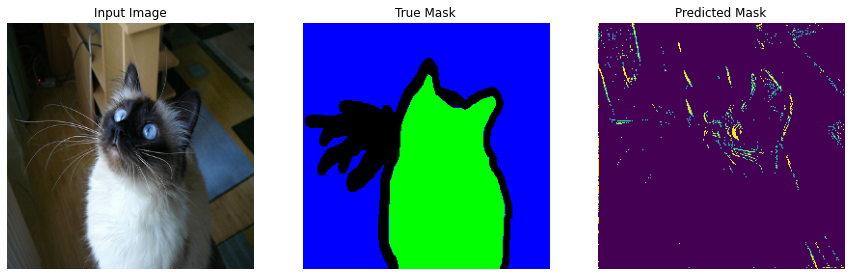

Epoch 1/100
  6/230 [..............................] - ETA: 34s - loss: 0.6043 - dice: 0.3957  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0222s vs `on_train_batch_end` time: 0.1091s). Check your callbacks.


230/230 [==============================] - 50s 194ms/step - loss: 0.1438 - dice: 0.8562 - val_loss: 0.0937 - val_dice: 0.9063

C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: .\best_model\assets


INFO:tensorflow:Assets written to: .\best_model\assets


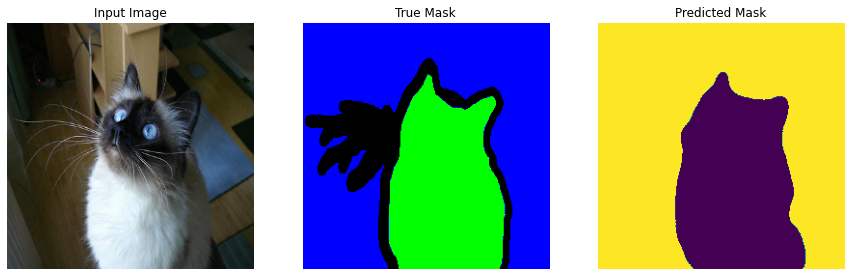


Sample Prediction after epoch 1

Epoch 2/100
230/230 [==============================] - 42s 183ms/step - loss: 0.0858 - dice: 0.9142 - val_loss: 0.0913 - val_dice: 0.9086

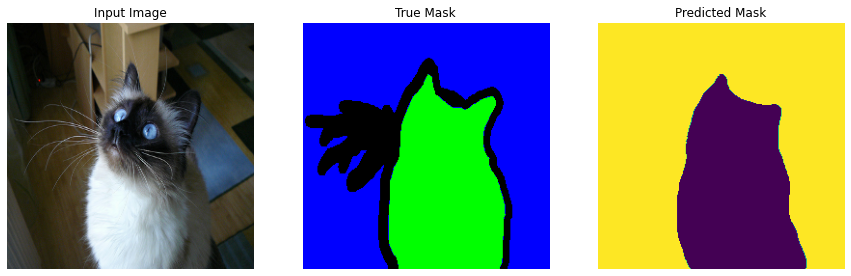


Sample Prediction after epoch 2

Epoch 3/100
230/230 [==============================] - 42s 183ms/step - loss: 0.0824 - dice: 0.9176 - val_loss: 0.0861 - val_dice: 0.9139

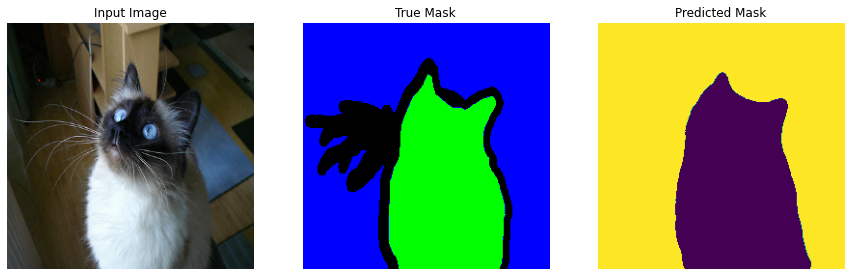


Sample Prediction after epoch 3

Epoch 4/100
230/230 [==============================] - 42s 183ms/step - loss: 0.0798 - dice: 0.9202 - val_loss: 0.0850 - val_dice: 0.9149

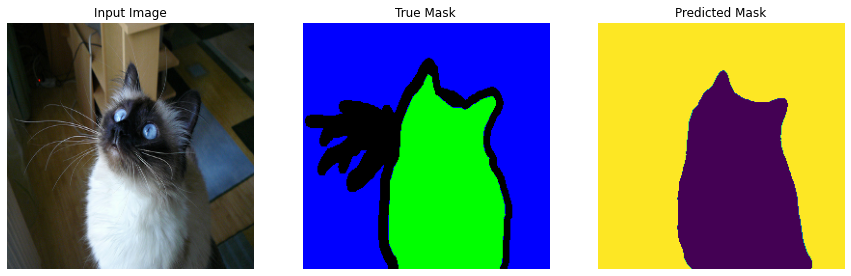


Sample Prediction after epoch 4

Epoch 5/100
230/230 [==============================] - 42s 183ms/step - loss: 0.0766 - dice: 0.9234 - val_loss: 0.0839 - val_dice: 0.9160

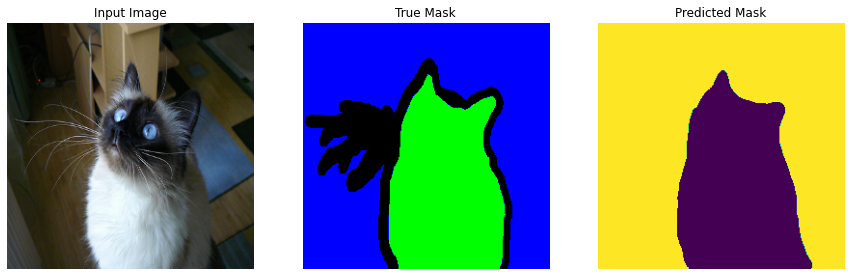


Sample Prediction after epoch 5

Epoch 6/100
230/230 [==============================] - 42s 183ms/step - loss: 0.0756 - dice: 0.9244 - val_loss: 0.0840 - val_dice: 0.9159

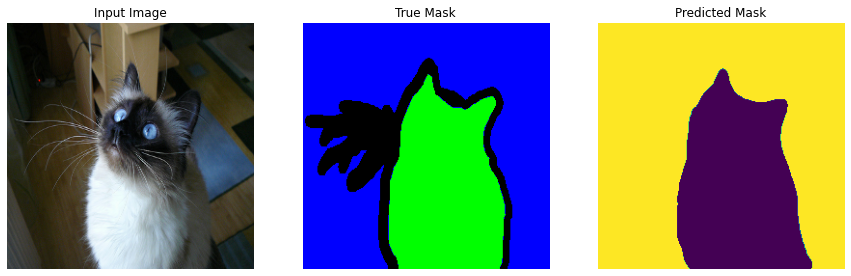


Sample Prediction after epoch 6

Epoch 7/100
230/230 [==============================] - 42s 183ms/step - loss: 0.0746 - dice: 0.9254 - val_loss: 0.0835 - val_dice: 0.9164

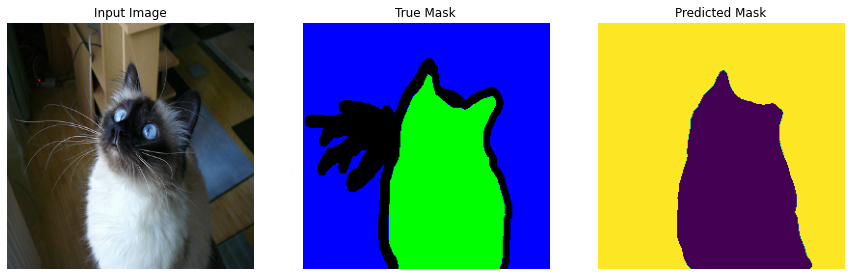


Sample Prediction after epoch 7

Epoch 8/100
230/230 [==============================] - 42s 183ms/step - loss: 0.0740 - dice: 0.9260 - val_loss: 0.0835 - val_dice: 0.9164

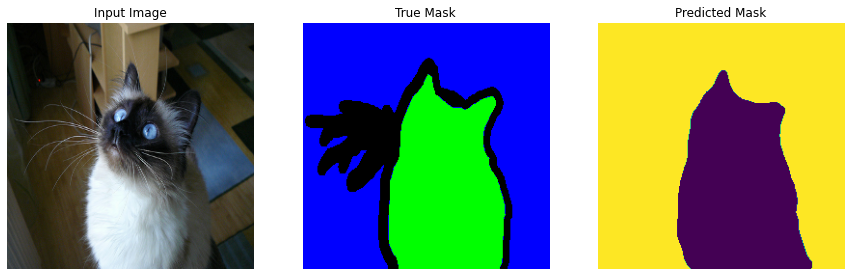


Sample Prediction after epoch 8

Epoch 9/100
230/230 [==============================] - 42s 183ms/step - loss: 0.0740 - dice: 0.9260 - val_loss: 0.0835 - val_dice: 0.9164

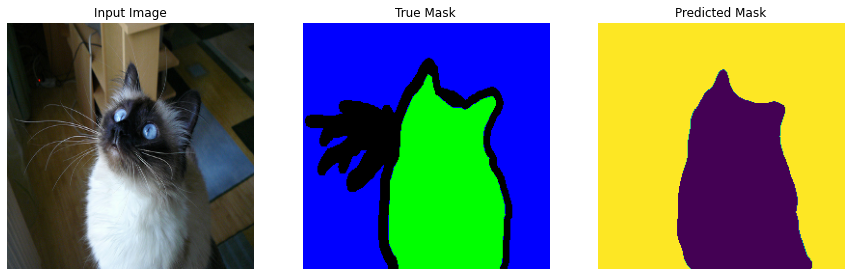


Sample Prediction after epoch 9

Epoch 10/100
230/230 [==============================] - 42s 184ms/step - loss: 0.0736 - dice: 0.9264 - val_loss: 0.0834 - val_dice: 0.9165

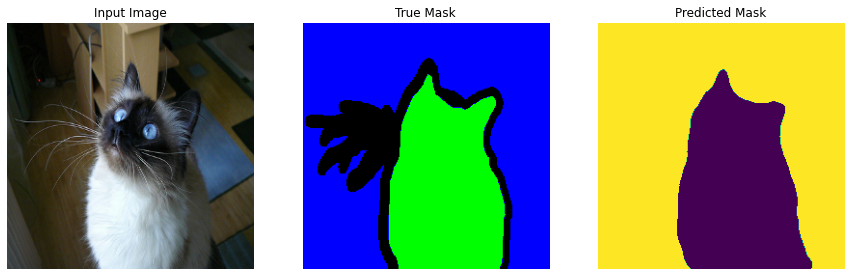


Sample Prediction after epoch 10

Epoch 11/100
230/230 [==============================] - 42s 184ms/step - loss: 0.0735 - dice: 0.9265 - val_loss: 0.0834 - val_dice: 0.9166

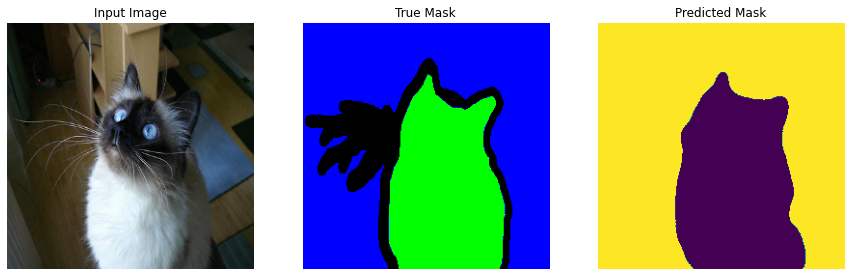


Sample Prediction after epoch 11

Epoch 00011: early stopping


In [5]:
print('Test predict:')
show_predictions()
history = model.fit(train_ds, epochs=epoch, validation_data=val_ds, callbacks=callbacks, verbose=1)

In [7]:
model.evaluate(test_ds)  # 0.9060
model.save('oxford pet Resnet50')


115/115 [==============================] - 8s 68ms/step - loss: 0.0940 - dice: 0.9060

C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: oxford pet Resnet50\assets


INFO:tensorflow:Assets written to: oxford pet Resnet50\assets
